In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
from tqdm import tqdm
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")

In [2]:
# 数据准备
train = pd.read_csv('../data/train_set.csv')
test = pd.read_csv('../data/test_set.csv')
data = pd.concat([train,test])
print(data.shape[0])
data.head(3)

36169


,ID,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous,y
0,1,43,291,2,unknown,9,no,150,tertiary,yes,management,no,married,may,-1,unknown,0,0.0
1,2,42,5076,1,cellular,7,no,99,primary,yes,technician,no,divorced,apr,251,other,2,0.0
2,3,47,104,2,cellular,14,no,77,secondary,yes,admin.,yes,married,jul,-1,unknown,0,0.0


In [4]:
train.shape[0],test.shape[0]

(25317, 10852)

In [6]:
# 查看正负样本情况
train[train['y']==0].shape[0],train[train['y']==1].shape[0]

(22356, 2961)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB3AD4D7F0>,
      dtype=object)

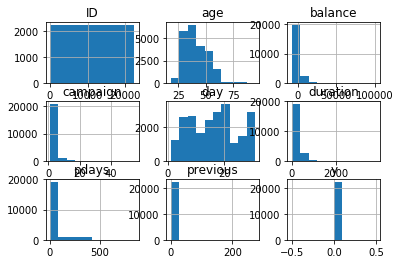

In [77]:
train[train['y']==0].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB417D6940>,
      dtype=object)

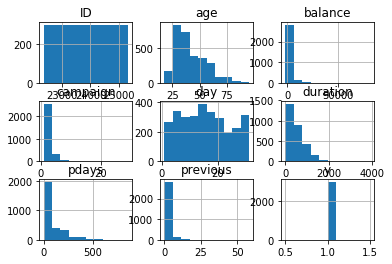

In [78]:
train[train['y']==1].hist()

In [80]:
train[train['y']==0].describe()

,ID,age,balance,day,duration,campaign,pdays,previous,y
count,22356.000000,22356.000000,22356.000000,22356.000000,22356.000000,22356.000000,22356.000000,22356.00000,22356.0
mean,11178.500000,40.819601,1294.711263,15.931830,220.815754,2.857846,36.325819,0.50917,0.0
std,6453.765645,10.178240,2928.450260,8.294048,205.157690,3.255113,96.600519,2.55005,0.0
min,1.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.00000,0.0
25%,5589.750000,33.000000,58.000000,8.000000,96.000000,1.000000,-1.000000,0.00000,0.0
50%,11178.500000,39.000000,414.500000,16.000000,165.000000,2.000000,-1.000000,0.00000,0.0
75%,16767.250000,48.000000,1347.250000,21.000000,278.000000,3.000000,-1.000000,0.00000,0.0
max,22356.000000,95.000000,102127.000000,31.000000,3785.000000,55.000000,850.000000,275.00000,0.0


In [81]:
train[train['y']==1].describe()

,ID,age,balance,day,duration,campaign,pdays,previous,y
count,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.000000,2961.0
mean,23837.000000,41.809524,1832.035461,15.106383,536.458629,2.124282,69.867612,1.215130,1.0
std,854.911399,13.562600,3455.787521,8.475033,398.627583,1.902191,120.094878,2.619957,0.0
min,22357.000000,18.000000,-1944.000000,1.000000,11.000000,1.000000,-1.000000,0.000000,1.0
25%,23097.000000,32.000000,230.000000,8.000000,238.000000,1.000000,-1.000000,0.000000,1.0
50%,23837.000000,38.000000,783.000000,15.000000,417.000000,2.000000,-1.000000,0.000000,1.0
75%,24577.000000,51.000000,2228.000000,21.000000,731.000000,2.000000,99.000000,2.000000,1.0
max,25317.000000,95.000000,81204.000000,31.000000,3881.000000,29.000000,854.000000,58.000000,1.0


In [85]:
del data['pdays']

# 法1：增加正样本

In [69]:
# train_0_add = train[train['y']==1].sample(n=500)

# data = pd.concat([data,train_0_add])
# data.shape[0]

36669

# 法2：减少负样本

In [67]:
train_0 = train[train['y']==0].sample(n=15000)
train_1 = train[train['y']==1]

data = pd.concat([train_0,train_1,test])
print(data.shape[0])
data.head(3)

28813


,ID,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous,y
4630,4631,36,655,4,unknown,23,no,153,primary,yes,blue-collar,no,married,may,-1,unknown,0,0.0
19845,19846,40,1777,4,cellular,18,no,81,tertiary,yes,management,no,married,nov,-1,unknown,0,0.0
12337,12338,32,72,9,cellular,28,no,88,secondary,no,services,no,single,jul,-1,unknown,0,0.0


In [139]:
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data,feature_name

feature = data.columns.tolist()
feature.remove('ID')
feature.remove('y')
sparse_feature = ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']
dense_feature = list(set(feature)-set(sparse_feature))

ll = []
for f in ['campaign', 'contact','default','education','housing','job','loan','marital','poutcome']:
    data,_ = feature_count(data,['day','month',f])
    ll.append(_)
    
def get_new_columns(name,aggs):
    l = []
    for k in aggs.keys():
        for agg in aggs[k]:
            if str(type(agg))=="<class 'function'>":
                l.append(name + '_' + k + '_' + 'other')
            else:
                l.append(name + '_' + k + '_' + agg)
    return l

for d in tqdm(sparse_feature):
    aggs={}
    for s in sparse_feature:
        aggs[s]=['count','nunique']
    for den in dense_feature:
        aggs[den]=['mean','max','min','std']
    aggs.pop(d)
    temp = data.groupby(d).agg(aggs).reset_index()
    temp.columns = [d]+get_new_columns(d,aggs)
    data = pd.merge(data,temp,on=d,how='left')
    
for s in ['contact','default','education','housing','job','loan','marital','month','poutcome']:
    data = pd.concat([data,pd.get_dummies(data[s],prefix=s+'_')],axis=1)
    data.drop(s,axis=1,inplace=True)

df_train = data[data['y'].notnull()]
df_test = data[data['y'].isnull()]

target = df_train['y']
df_train_columns = df_train.columns.tolist()
df_train_columns.remove('ID')
df_train_columns.remove('y')





  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.28it/s]

 20%|████████████████▌                                                                  | 2/10 [00:00<00:03,  2.14it/s]

 30%|████████████████████████▉                                                          | 3/10 [00:01<00:03,  1.78it/s]

 40%|█████████████████████████████████▏                                                 | 4/10 [00:02<00:04,  1.33it/s]

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:04<00:05,  1.02s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:06<00:05,  1.37s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:05,  1.83s/it]

 80%|█████████████████████████

In [119]:
len(df_train_columns)

545

# 画图

In [141]:
df_train = df_train.fillna(-1)

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split( df_train[df_train_columns],df_train[['y']],
                                                 test_size=0.2,random_state=0 )

In [31]:
y_train.shape[0]

10368

# RF

In [142]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor( max_depth=10,random_state=600,
                             n_estimators=100)

regr.fit(X_train,y_train)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=600, verbose=0, warm_start=False)

In [143]:
pred_rf = regr.predict(X_test)
pred_rf

array([0.00273861, 0.00286224, 0.38029934, ..., 0.07596366, 0.03348166,
       0.00253678])

In [144]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test[['y']],pred_rf)

0.9329805697726539

In [148]:
feature_importances_sort = pd.DataFrame([X_train.columns.values,regr.feature_importances_]).T.rename(
    columns={0:'feature',1:'importances'}).sort_values(by=['importances'],ascending=False)
feature_importances_sort

,feature,importances
3,duration,0.324465
52,count_day_month_poutcome,0.223093
0,age,0.0320616
1,balance,0.0313826
45,count_day_month_contact,0.0280684
43,poutcome_campaign_count,0.026986
48,count_day_month_housing,0.0261143
2,day,0.0255629
51,count_day_month_marital,0.0219434
4,pdays,0.0197532


In [149]:
feature_importances = feature_importances_sort[feature_importances_sort['importances']>0.0005]['feature'].values
feature_importances

array(['duration', 'count_day_month_poutcome', 'age', 'balance',
       'count_day_month_contact', 'poutcome_campaign_count',
       'count_day_month_housing', 'day', 'count_day_month_marital',
       'pdays', 'count_day_month_campaign', 'count_day_month_job',
       'count_day_month_education', 'contact_campaign_count',
       'count_day_month_loan', 'count_day_month_default',
       'housing_campaign_count', 'month_day_std', 'previous',
       'job_day_mean', 'job_duration_mean', 'contact_duration_max',
       'month_day_mean', 'job_duration_max', 'job_pdays_max',
       'job_previous_mean', 'job_day_std', 'month_pdays_std',
       'job_age_max', 'job_age_std', 'month_duration_mean',
       'month_pdays_mean', 'job_campaign_count', 'job_age_mean',
       'campaign_day_std', 'education_duration_mean',
       'marital_campaign_count', 'month_age_mean', 'campaign_balance_min',
       'campaign_previous_std', 'month_age_max', 'month_balance_mean',
       'month_pdays_max', 'month_previou

# xgboost

In [138]:
import xgboost as xgb

xgb_clf = xgb.XGBRegressor(max_depth=10, learning_rate=0.028, n_estimators=500, silent=False, objective='binary:logistic')
xgb_clf.fit(X_train[df_train_columns], y_train)

y_pred_xgb = xgb_clf.predict(X_test[df_train_columns])

# auc
roc_auc_score(y_test[['y']],y_pred_xgb)

0.9346597550969352

In [136]:
y_pred_xgb

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

# LightBGM

In [150]:
df_train_columns=['age',
 'balance',
 'day',
 'duration',
 'pdays',
 'previous',
 'campaign_contact_count',
 'campaign_duration_max',
 'campaign_duration_std',
 'campaign_age_max',
 'campaign_day_std',
 'campaign_balance_min',
 'campaign_previous_std',
 'contact_campaign_count',
 'contact_duration_max',
 'education_campaign_count',
 'education_duration_mean',
 'housing_campaign_count',
 'job_campaign_count',
 'job_duration_mean',
 'job_duration_max',
 'job_age_mean',
 'job_age_max',
 'job_age_std',
 'job_day_mean',
 'job_day_std',
 'job_pdays_max',
 'job_previous_mean',
 'loan_campaign_count',
 'marital_campaign_count',
 'month_campaign_count',
 'month_campaign_nunique',
 'month_duration_mean',
 'month_age_mean',
 'month_age_max',
 'month_day_mean',
 'month_day_std',
 'month_pdays_mean',
 'month_pdays_max',
 'month_pdays_std',
 'month_balance_mean',
 'month_previous_max',
 'month_previous_std',
 'poutcome_campaign_count',
 'count_day_month_campaign',
 'count_day_month_contact',
 'count_day_month_default',
 'count_day_month_education',
 'count_day_month_housing',
 'count_day_month_job',
 'count_day_month_loan',
 'count_day_month_marital',
 'count_day_month_poutcome'
                 ]

df_train_columns = feature_importances
 

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 10,
         'learning_rate': 0.028,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.95,
         "bagging_freq": 1,
         "bagging_fraction": 0.95 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 666}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=666,)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['y'].values)):
    print("fold {}".format(fold_))
    print(len(trn_idx))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
#     oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    oof[val_idx] += clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)/ folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
from sklearn.metrics import roc_auc_score
print("交叉验证，整体：")
roc_auc_score(target,oof)



fold 0
22784
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.95633	valid_1's auc: 0.940276
[200]	training's auc: 0.968821	valid_1's auc: 0.94169
[300]	training's auc: 0.977261	valid_1's auc: 0.941448
Early stopping, best iteration is:
[266]	training's auc: 0.974632	valid_1's auc: 0.941848
fold 1
22785
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.956439	valid_1's auc: 0.93924
[200]	training's auc: 0.968195	valid_1's auc: 0.942297
[300]	training's auc: 0.976652	valid_1's auc: 0.942181
Early stopping, best iteration is:
[244]	training's auc: 0.972242	valid_1's auc: 0.942507
fold 2
22785
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.956755	valid_1's auc: 0.934189
[200]	training's auc: 0.969022	valid_1's auc: 0.935586
[300]	training's auc: 0.977347	valid_1's auc: 0.935935
[400]	training's auc: 0.983436	valid_1's auc: 0.936062
Early stopping, best iteration is:
[335]	trai

0.9405172049671313

In [124]:
folds

StratifiedKFold(n_splits=5, random_state=1000, shuffle=True)

In [151]:
sub = df_test[['ID']]
sub['pred'] = predictions
sub.to_csv('../data/Result.csv',index=False)

In [171]:
sub.head()

,ID,pred
25317,25318,0.033489
25318,25319,0.001760
25319,25320,0.003983
25320,25321,0.686017
25321,25322,0.015135
